In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install timm

In [3]:
import cv2 as cv
from google.colab.patches import cv2_imshow
import torch
import numpy as np
import matplotlib.pyplot as plt

In [4]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)
midas = torch.hub.load("intel-isl/MiDaS", model_type)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt
100%|██████████| 1.28G/1.28G [00:10<00:00, 135MB/s]


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

In [6]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [7]:
from zipfile import ZipFile
import io

def getImageFromZip(zipobj, fname, imreadFlag):
  if fname in zipobj.namelist():
    image_data = zipobj.read(fname)
    image_buffer = io.BytesIO(image_data)
    return cv.imdecode(np.frombuffer(image_buffer.getvalue(), np.uint8), imreadFlag)
  else:
    raise ValueError("Error, given file does not exit")

In [8]:
path = "drive/My Drive/Colab Notebooks/Datasets/"
zip_file = path+"rgbd-scene-time-lapses.zip"
zipf = ZipFile(zip_file, 'r')

In [9]:
zipf.namelist()[:20]

['chess/TestSplit.txt',
 'chess/TrainSplit.txt',
 'chess/chess.png',
 'chess/seq-01/frame-000000.color.png',
 'chess/seq-01/frame-000000.depth.png',
 'chess/seq-01/frame-000000.pose.txt',
 'chess/seq-01/frame-000001.color.png',
 'chess/seq-01/frame-000001.depth.png',
 'chess/seq-01/frame-000001.pose.txt',
 'chess/seq-01/frame-000002.color.png',
 'chess/seq-01/frame-000002.depth.png',
 'chess/seq-01/frame-000002.pose.txt',
 'chess/seq-01/frame-000003.color.png',
 'chess/seq-01/frame-000003.depth.png',
 'chess/seq-01/frame-000003.pose.txt',
 'chess/seq-01/frame-000004.color.png',
 'chess/seq-01/frame-000004.depth.png',
 'chess/seq-01/frame-000004.pose.txt',
 'chess/seq-01/frame-000005.color.png',
 'chess/seq-01/frame-000005.depth.png']

In [161]:
!mkdir "drive/My Drive/ENS491 Bitirme Projesi/Tests/chess_color/"

In [164]:
for i in range(10):
  img = getImageFromZip(zipf, f"chess/seq-01/frame-000{i}00.color.png", cv.IMREAD_COLOR)
  cv.imwrite(f"drive/My Drive/ENS491 Bitirme Projesi/Tests/chess_color/chess_color{i}.png", img)

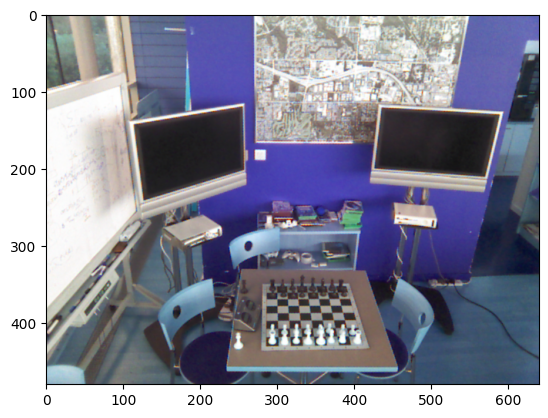

In [177]:
plt.imshow(getImageFromZip(zipf, f"chess/seq-01/frame-000000.color.png", cv.IMREAD_COLOR))

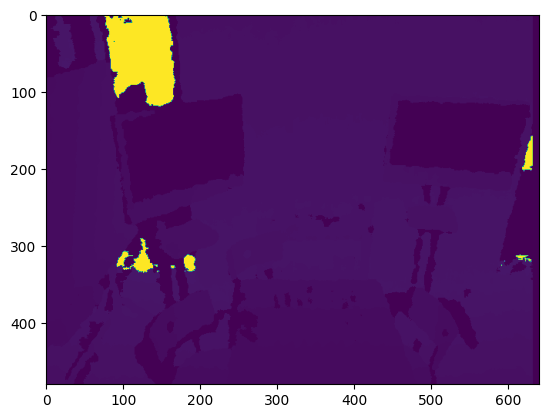

In [174]:
plt.imshow(getImageFromZip(zipf, f"chess/seq-01/frame-000000.depth.png", cv.IMREAD_ANYDEPTH))

In [51]:
img = getImageFromZip(zipf, "chess/seq-01/frame-000001.color.png", cv.IMREAD_COLOR)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

In [52]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

In [60]:
def predMidas(img):
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  input_batch = transform(img).to(device)
  with torch.no_grad():
    prediction = midas(input_batch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
  return prediction.cpu().numpy()

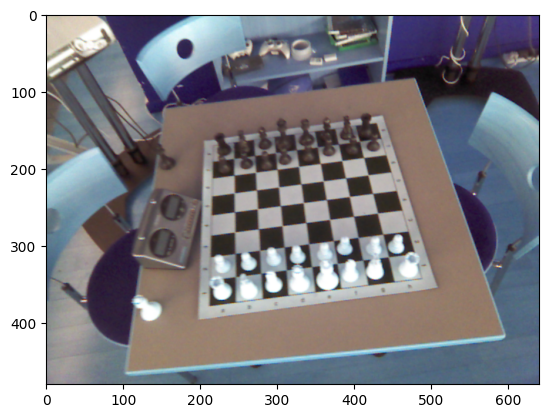

In [93]:
plt.imshow(getImageFromZip(zipf, "chess/seq-01/frame-000150.color.png", cv.IMREAD_COLOR))

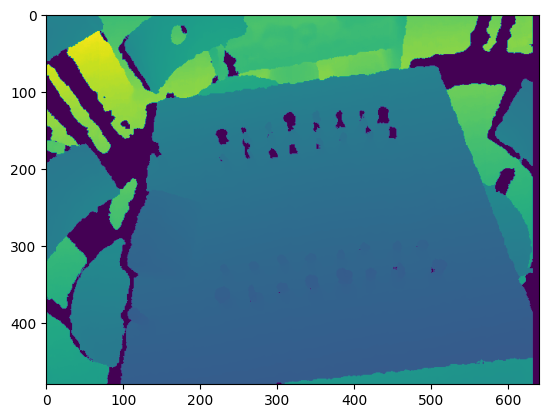

In [94]:
plt.imshow(getImageFromZip(zipf, "chess/seq-01/frame-000150.depth.png", cv.IMREAD_ANYDEPTH))

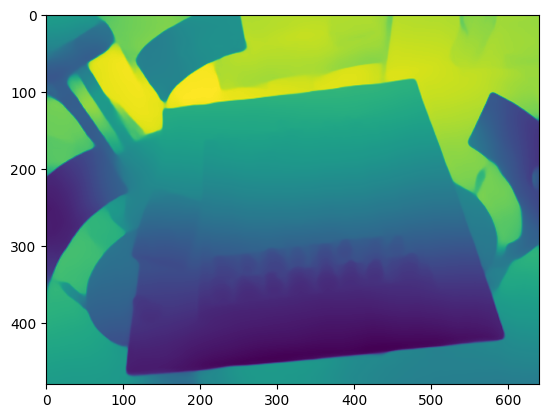

In [144]:
output = predMidas(getImageFromZip(zipf, "chess/seq-01/frame-000150.color.png", cv.IMREAD_COLOR))
plt.imshow(((1<<8)-1) - output)

In [ ]:
plt.imshow()

In [146]:
import numpy as np
import cv2

# Read the two images
imagex = output
imagey = getImageFromZip(zipf, f"chess/seq-01/frame-000150.depth.png", cv.IMREAD_ANYDEPTH)

# Convert the 8-bit image to 16-bit
imagey_16bit = imagey.astype(np.uint16)

# Flatten the images
flat_imagey = imagey_16bit.flatten()
flat_imagex = imagex.flatten()

# Perform linear regression
coefficients = np.polyfit(flat_imagex, flat_imagey, 1)

# Get the slope and intercept of the linear function
slope, intercept = coefficients

# Predict the values of image2 based on image1 using the linear function
predicted_image = slope * flat_imagex + intercept

# Calculate the error between the predicted values and the actual values
error = np.mean((predicted_image - flat_imagey) ** 2) ** 0.5

print("Linear relationship parameters:")
print("Slope:", slope)
print("Intercept:", intercept)
print("Mean squared error:", error)

Linear relationship parameters:
Slope: -28.343277444809974
Intercept: 1569.194672446432
Mean squared error: 558.3670947503981


In [129]:
hrange = 1<<12
hbin = 1<<12
def makeHist(img):
  histogram = cv.calcHist(images=[img], channels=[0], mask=None, histSize=[hbin], ranges=[0,hrange])
  return histogram

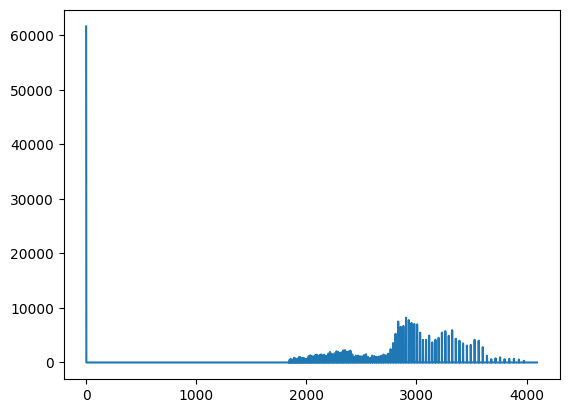

In [175]:
plt.plot(makeHist(getImageFromZip(zipf, f"chess/seq-01/frame-000000.depth.png", cv.IMREAD_ANYDEPTH)))

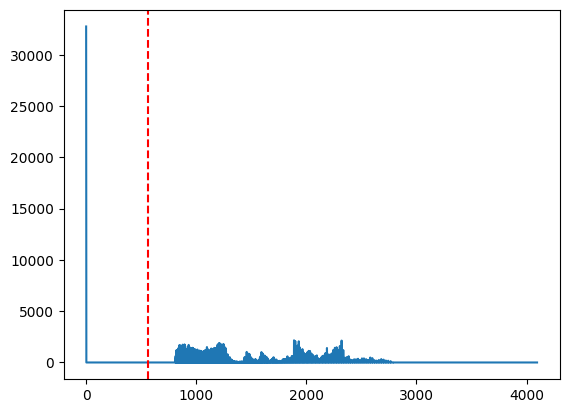

In [130]:
plt.plot(makeHist(getImageFromZip(zipf, f"chess/seq-01/frame-000150.depth.png", cv.IMREAD_ANYDEPTH)))
plt.axvline(x=error*(hbin/hrange), color='r', linestyle='--')

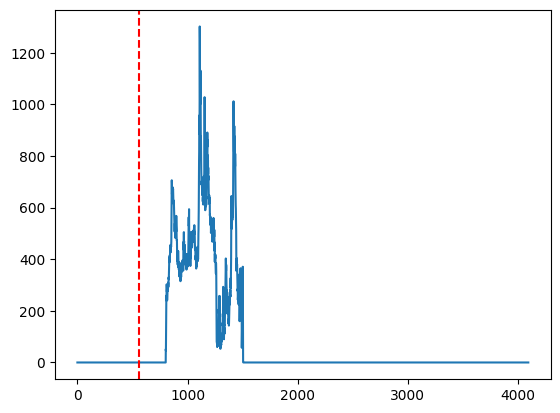

In [131]:
histogram = makeHist(predicted_image.reshape(640,480))
plt.plot(histogram)
plt.axvline(x=error*(hbin/hrange), color='r', linestyle='--')

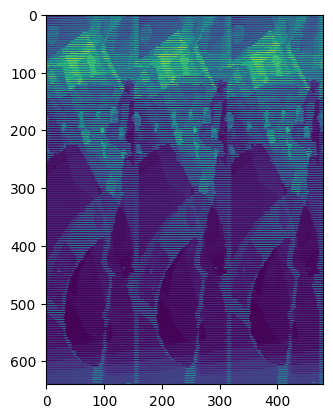

In [132]:
absdif_image = np.abs(predicted_image - flat_imagey).reshape((640,480))
plt.imshow(absdif_image)

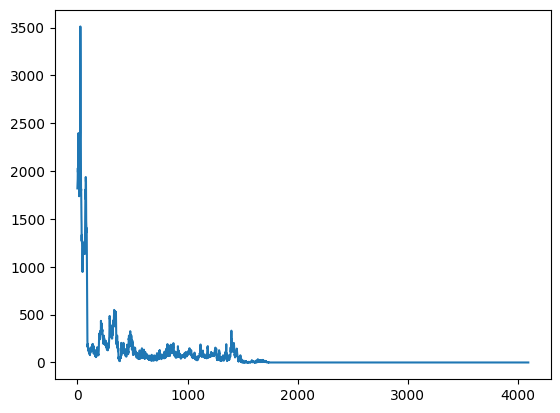

In [133]:
histogram = makeHist(absdif_image)
plt.plot(histogram)

In [ ]:
patched_cimg = getImageFromZip(zipf, "chess/seq-01/frame-000000.color.png", cv.IMREAD_COLOR)
patched_dimg = getImageFromZip(zipf, "chess/seq-01/frame-000000.depth.png", cv.IMREAD_ANYDEPTH)
f, axarr = plt.subplots(2,2,figsize=(12,6))
axarr[0,0].imshow(patched_cimg)

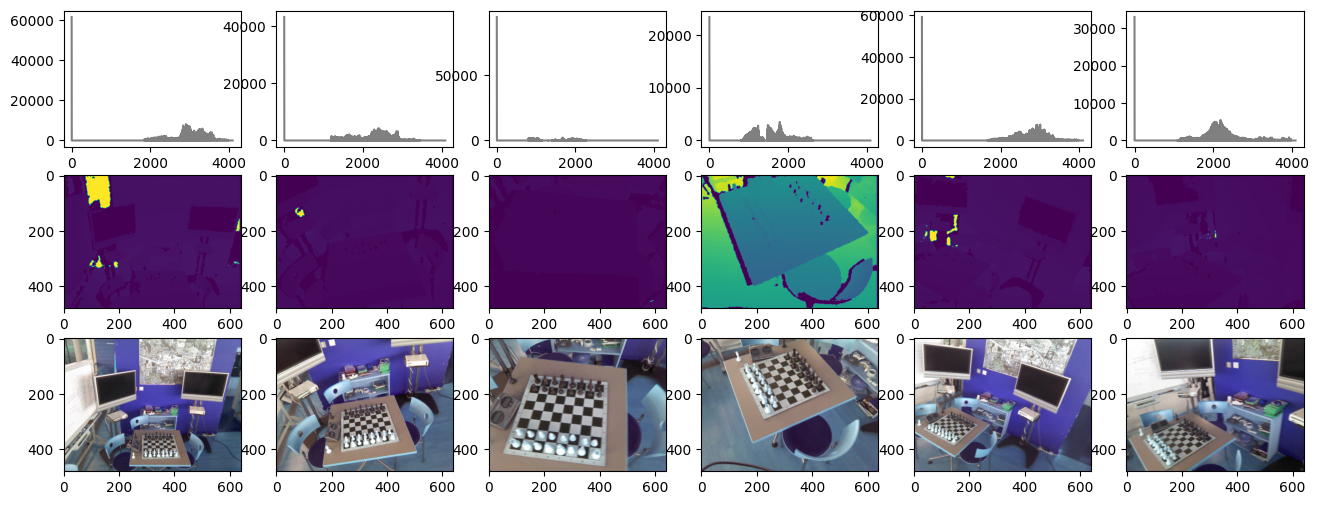

In [77]:
f, axarr = plt.subplots(3,6,figsize=(16,6))
for i in range(6):
  imgg = getImageFromZip(zipf, f"chess/seq-01/frame-000{i}00.depth.png", cv.IMREAD_ANYDEPTH)
  # Check if the image is grayscale
  if len(imgg.shape) == 2:  # Check if image is grayscale
      # Calculate the histogram
      histogram = cv.calcHist([imgg], [0], None, [(1<<12)-1], [0, (1<<12)-1])
      """
      # Plot the histogram
      plt.plot(histogram, color='gray')
      plt.xlabel('Pixel Intensity')
      plt.ylabel('Frequency')
      plt.title('Histogram of Image')
      plt.show()
      """
      axarr[0,i].plot(histogram, color='gray')
      axarr[1,i].imshow(imgg)
      axarr[2,i].imshow(getImageFromZip(zipf, f"chess/seq-01/frame-000{i}00.color.png", cv.IMREAD_COLOR))
  else:
      print("The image is not grayscale. Please convert it to grayscale first.")
      break

In [ ]:
f, axarr = plt.subplots(3,6,figsize=(16,6))
for i in range(6):
  imgg = getImageFromZip(zipf, f"chess/seq-01/frame-000{i}00.depth.png", cv.IMREAD_ANYDEPTH)
  # Check if the image is grayscale
  if len(imgg.shape) == 2:  # Check if image is grayscale
      # Calculate the histogram
      histogram = cv.calcHist([imgg], [0], None, [(1<<12)-1], [0, (1<<12)-1])
      """
      # Plot the histogram
      plt.plot(histogram, color='gray')
      plt.xlabel('Pixel Intensity')
      plt.ylabel('Frequency')
      plt.title('Histogram of Image')
      plt.show()
      """
      axarr[0,i].plot(histogram, color='gray')
      axarr[1,i].imshow(imgg)
      axarr[2,i].imshow(getImageFromZip(zipf, f"chess/seq-01/frame-000{i}00.color.png", cv.IMREAD_COLOR))
  else:
      print("The image is not grayscale. Please convert it to grayscale first.")
      break

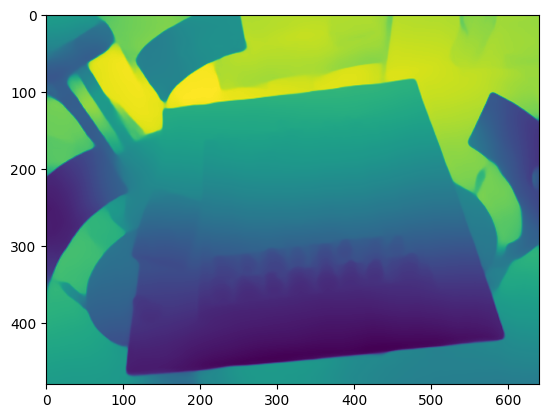

In [135]:
plt.imshow(255-output)

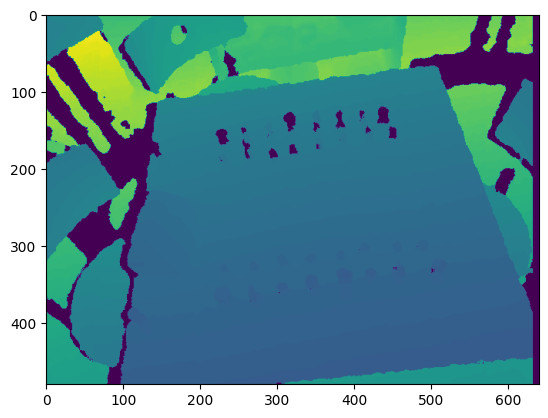

In [143]:
imgr = getImageFromZip(zipf, f"chess/seq-01/frame-000150.depth.png", cv.IMREAD_ANYDEPTH)
imgr = ((imgr - intercept)/slope)
imgr8 = imgr.astype(np.int8)
plt.imshow(255-imgr8)

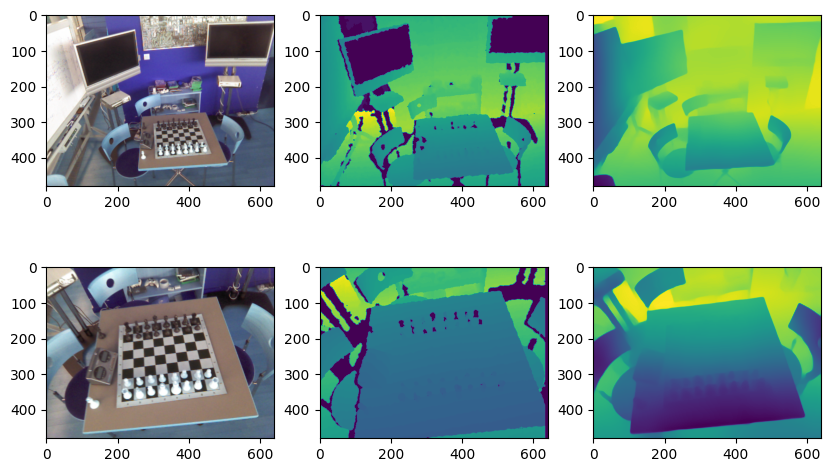

In [153]:
f, axarr = plt.subplots(2,3,figsize=(10,6))
for i in range(2):
  imgc = getImageFromZip(zipf, f"chess/seq-01/frame-000{i}50.color.png", cv.IMREAD_COLOR)
  imgd = getImageFromZip(zipf, f"chess/seq-01/frame-000{i}50.depth.png", cv.IMREAD_ANYDEPTH)
  axarr[i,0].imshow(imgc)
  axarr[i,1].imshow(255-((imgd - intercept)/slope).astype(np.int8))
  axarr[i,2].imshow(255-predMidas(imgc))

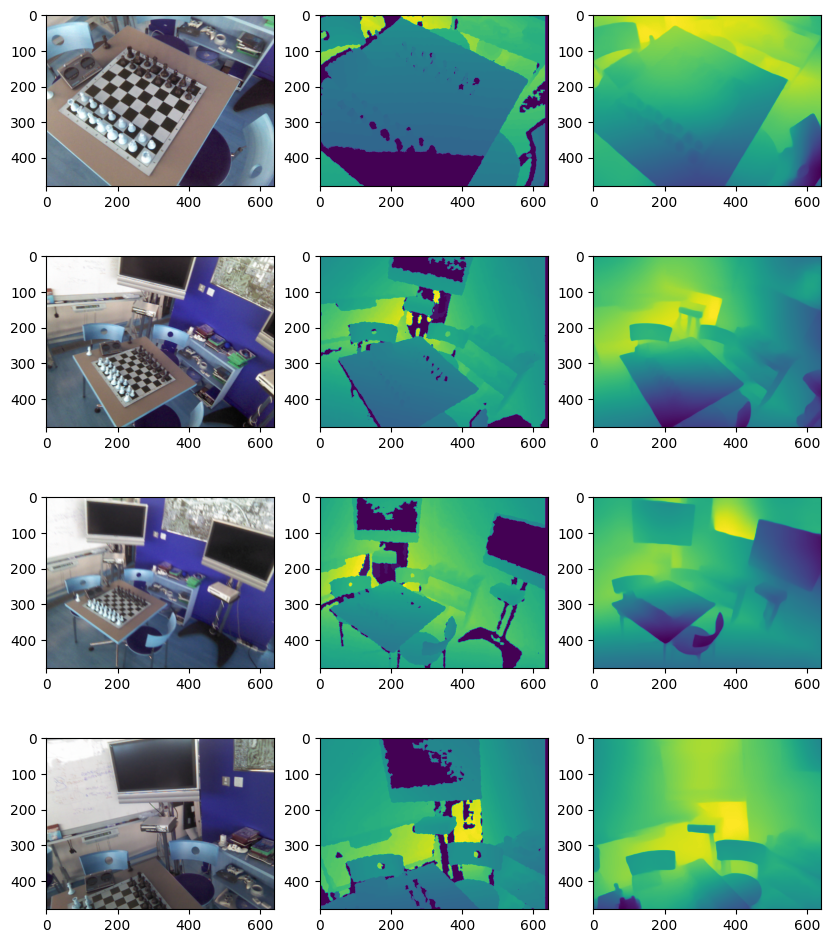

In [156]:
f, axarr = plt.subplots(4,4,figsize=(10,6*2))
for i in range(2,6):
  imgc = getImageFromZip(zipf, f"chess/seq-01/frame-000{i}50.color.png", cv.IMREAD_COLOR)
  imgd = getImageFromZip(zipf, f"chess/seq-01/frame-000{i}50.depth.png", cv.IMREAD_ANYDEPTH)
  hist = makeHist(imgd)
  axarr[i-2,0].imshow(imgc)
  axarr[i-2,1].imshow(255-((imgd - intercept)/slope).astype(np.int8))
  axarr[i-2,2].imshow(255-predMidas(imgc))
  axarr[i-2,3].imshow(hist)

In [178]:
def fitLin(depth, pred):
  imagex = pred
  imagey = depth

  # Convert the 8-bit image to 16-bit
  imagey_16bit = imagey.astype(np.uint16)

  # Flatten the images
  flat_imagey = imagey_16bit.flatten()
  flat_imagex = imagex.flatten()

  # Perform linear regression
  coefficients = np.polyfit(flat_imagex, flat_imagey, 1)

  # Get the slope and intercept of the linear function
  slope, intercept = coefficients

  # Predict the values of image2 based on image1 using the linear function
  predicted_image = slope * flat_imagex + intercept

  # Calculate the error between the predicted values and the actual values
  error = np.mean((predicted_image - flat_imagey) ** 2) ** 0.5
  return (slope, intercept, error)

error: 499.2478874517147


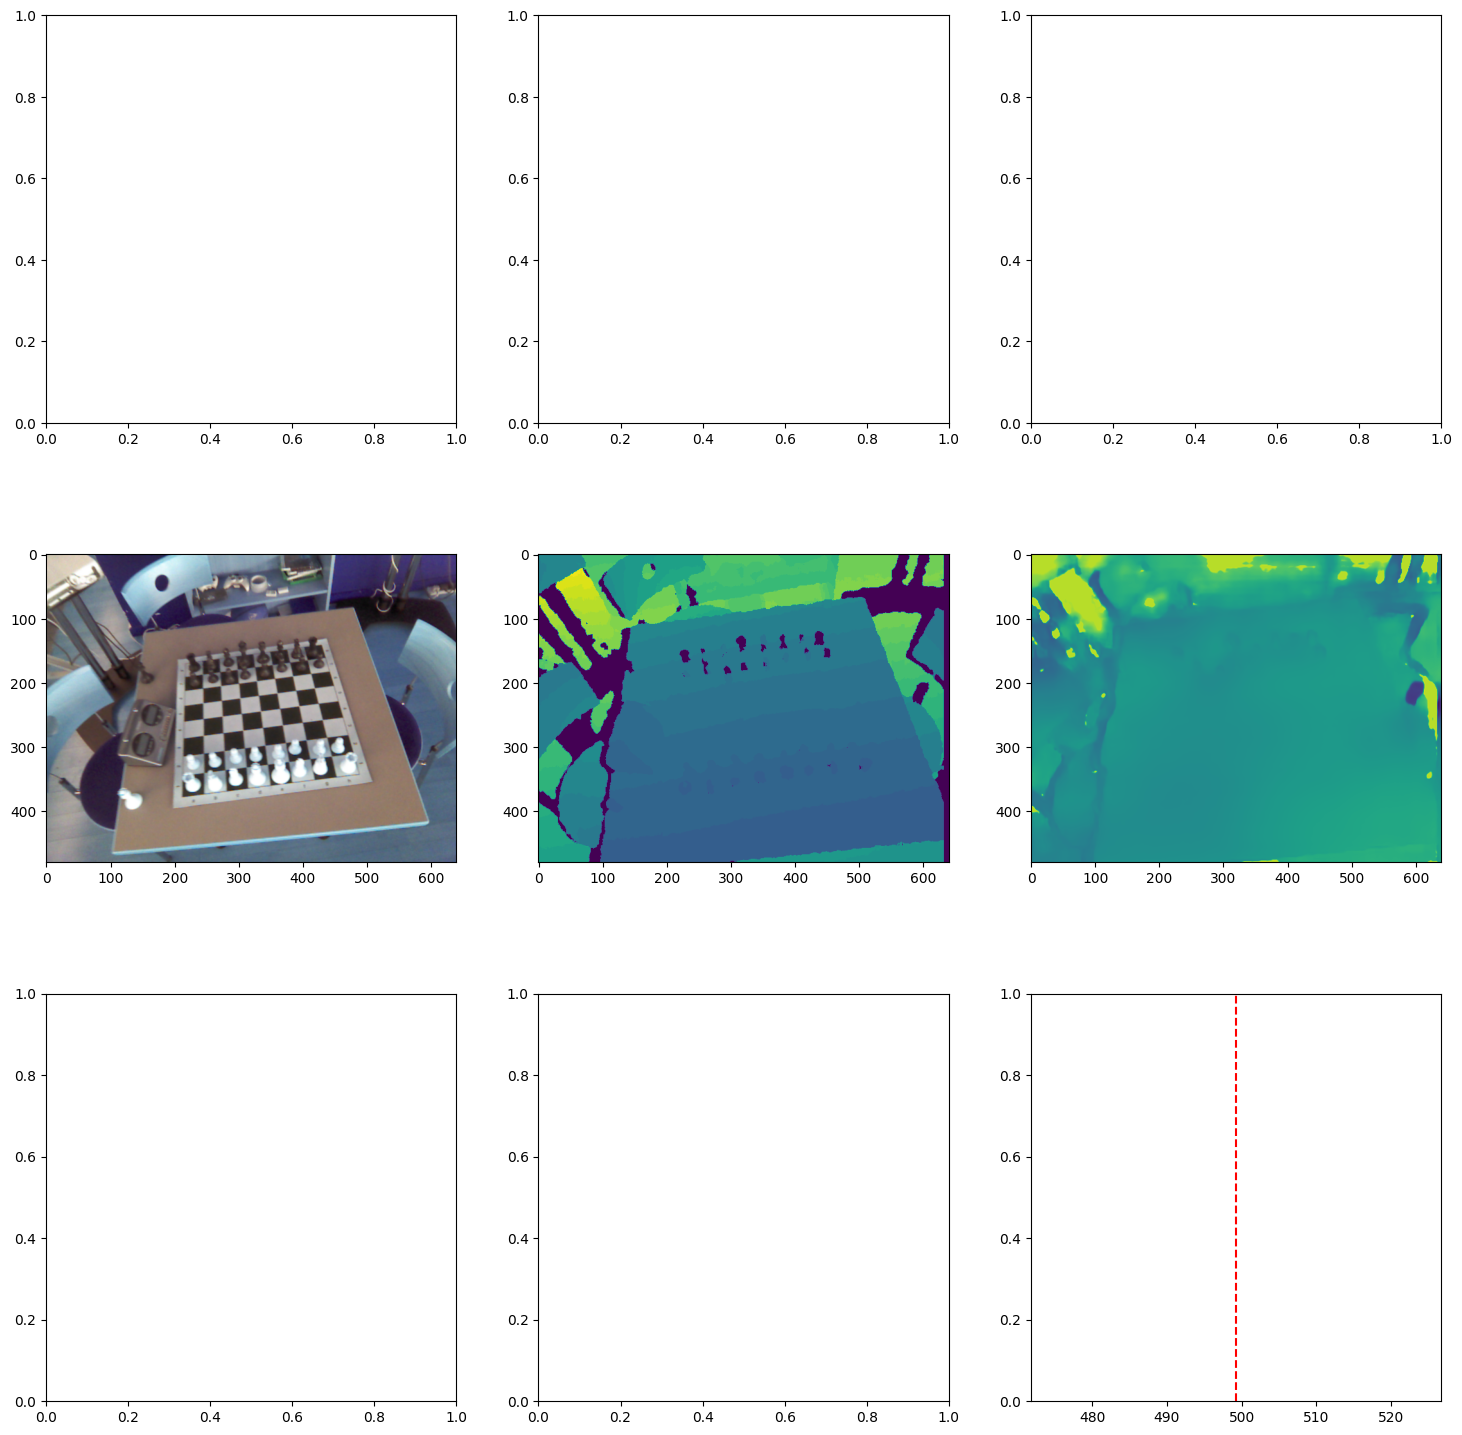

In [171]:
f, axarr = plt.subplots(3,3,figsize=(18,6*3))
for i in range(1,2):
  imgc = getImageFromZip(zipf, f"chess/seq-01/frame-000{i}50.color.png", cv.IMREAD_COLOR)
  imgd = getImageFromZip(zipf, f"chess/seq-01/frame-000{i}50.depth.png", cv.IMREAD_ANYDEPTH)
  pred = predMidas(imgd)
  # fit model for this prediction
  cof = fitLin(imgd, pred)
  #hist_org = makeHist(imgd)
  #hist_pred = makeHist((cof[0] * pred) + cof[1])
  print("error:",cof[2])
  axarr[i,0].imshow(imgc)
  axarr[i,1].imshow(255-((imgd - cof[1])/cof[0]).astype(np.int8))
  axarr[i,2].imshow(255-pred)
  #axarr[i,3].imshow(hist_org)
  #axarr[i,4].imshow(hist_pred)
  plt.axvline(x=cof[2]*(hbin/hrange), color='r', linestyle='--')